# LSTM Multi-Feature Stock Price Prediction with Keras

# Overview

This is a LSTM daily stock price and trade volume forecast project using four features (AAPL and SPY's closing price and volume), 10-step inputs, and final-step output. 


# Background for LSTM
The long short-term memory (LSTM) unit is an improved version of gated recurrent unit (GRU), which tries to resolve the [vanishing gradient problem](http://neuralnetworksanddeeplearning.com/chap5.html) and keep the long term "memory" activated.

See my other [project](https://github.com/ginochen/LSTM/blob/master/LSTM_min_temp.ipynb) for a picture summary on the network architecture.

# Data 
Daily data of [AAPL](https://finance.yahoo.com/quote/AAPL/history?p=AAPL) and [SPY](https://finance.yahoo.com/quote/SPY/history?p=SPY&.tsrc=fin-srch) downloaded from Yahoo Finance.

Then create batches of data with a generator:

In [719]:
class KerasBatchGenerator(object):

#    def __init__(self, data, num_steps, batch_size, vocabulary, skip_step=5):
    def __init__(self, data, num_steps, batch_size, ndim, skip_step=5):
        self.data = data
        self.num_steps = num_steps # forecast time steps
        self.batch_size = batch_size 
        self.ndim = ndim # number of feature dimensions
        # this will track the progress of the batches sequentially through the
        # data set - once the data reaches the end of the data set it will reset
        # back to zero
        self.current_idx = 0
        # skip_step is the number of words which will be skipped before the next
        # batch is skimmed from the data set
        self.skip_step = skip_step

    def generate(self):
        x = np.zeros((self.batch_size, self.num_steps, self.ndim))
        y = np.zeros((self.batch_size, self.ndim))# make sure to set the last dim to one element, otherwise Keras won't `fit` the model!!!!!!!!!!!!!!!
#        y = np.zeros((self.batch_size, self.num_steps))# if timedistributed not used
        while True:
            for i in range(self.batch_size):
                if self.current_idx + self.num_steps >= len(self.data):
                    # reset the index back to the start of the data set
                    self.current_idx = 0
                # Many-to-one (multiple inputs to one output in the end)    
                x[i,:,:], y[i,:] = many_to_one(self)
                # Many-to-many (multiple inputs to multiple outputs)
                #x[i,:,:], y[i,:,:] = many_to_many(self)
                self.current_idx += self.skip_step                
            yield x, y
    def many_to_many(self):
        x = self.data[self.current_idx    :self.current_idx + self.num_steps,    :] # (batchsize,nstep,ndim)
        y = self.data[self.current_idx + 1:self.current_idx + self.num_steps + 1,:]
        return x,y
    def many_to_one(self):   
        x = self.data[self.current_idx    :self.current_idx + self.num_steps,    :]
        y = self.data[self.current_idx + self.num_steps + 1,:]
        return x,y

In [720]:
def inverse_transform(x_std, xmin, xmax): # this function is not used, but 
    return x_std*(xmax-xmin) + xmin

Import and create the batched data: 

In [888]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
datapath = 'data/'
series_aapl = pd.read_csv('data/AAPL.csv')
series_spy = pd.read_csv('data/SPY.csv')
#series = pd.concat([series_aapl['Close'],series_aapl['Volume'],series_spy['Close'],series_spy['Volume']],axis=1)
series = np.stack((series_aapl['Close'].values,series_aapl['Volume'].values,series_spy['Close'].values,series_spy['Volume'].values),axis=1)
n = series.shape[0] # total time series length
nsteps = 10
batchsize = 20 # Number of samples per gradient update.
lagt=1
ndim = series.shape[1] # number of features
# split data into 80% training, 10% validating,10% testing
train,valid,test = series[:round(0.8*n),:], series[round(0.8*n):round(0.9*n),:], series[round(0.9*n):,:]
print('Train data snippet: \n AAPL closing price, AAPL trading volume, SPY closing price, SPY trading volume \n',train[:5,:])
# scale the data into range of X.min = 0 to X.max = 1
scaler = MinMaxScaler()
# Transformation is given by:
# X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
# X_scaled = X_std * (max - min) + min = X_std * 1 + 0 = X_std when scaled between (0,1)
# X = X_std*(X.max - X.min) + X.min
scaler.fit(test)
xmin, xmax = scaler.data_min_, scaler.data_max_

train = scaler.fit_transform(X=train)
valid = scaler.fit_transform(X=valid)
test  = scaler.fit_transform(X=test)
print('\nTransformed data snippet:\n', train[:5])

# create batched data
train_data_generator = KerasBatchGenerator(train, nsteps, batchsize, ndim, skip_step=nsteps)
valid_data_generator = KerasBatchGenerator(valid, nsteps, batchsize, ndim, skip_step=nsteps)

#x_train,x_valid        = series[:round(0.8*n)], series[round(0.8*n):round(0.9*n)]
#y_train,y_valid,y_test = series.iloc[:,0][lagt:round(0.8*n)+lagt], series.iloc[:,0][round(0.8*n)+lagt:round(0.9*n)+lagt], series.iloc[:,0][round(0.9*n)+lagt:]
print('\n Shape of training and validation data set:\n',train.shape,valid.shape)


Train data snippet: 
 AAPL closing price, AAPL trading volume, SPY closing price, SPY trading volume 
 [[4.55171430e+01 7.04396000e+07 1.22489998e+02 1.56107100e+08]
 [4.51542850e+01 9.58860000e+07 1.21610001e+02 1.86621600e+08]
 [4.54328580e+01 9.60568000e+07 1.22099998e+02 2.21387400e+08]
 [4.52357140e+01 9.03210000e+07 1.21639999e+02 1.58017600e+08]
 [4.40042840e+01 1.98961700e+08 1.20199997e+02 2.39068800e+08]]

Transformed data snippet:
 [[0.02541768 0.12852461 0.09672698 0.17585049]
 [0.02185471 0.18399075 0.08994995 0.2206209 ]
 [0.02459007 0.18436305 0.09372351 0.27162876]
 [0.02265428 0.17186059 0.09018097 0.17865354]
 [0.01056264 0.40866737 0.07909124 0.29757065]]

 Shape of training and validation data set:
 (1612, 4) (202, 4)


# Build and train the model

In [871]:
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, LSTM, TimeDistributed,Activation
import numpy as np
hdim = 128
nepochs = 200
model = Sequential()
model.add(LSTM(hdim, input_shape=(nsteps,ndim), return_sequences=True)) #input_shape required only at the first layer
# units: hidden nodes
# Input: (batch_size, timesteps, input_dim) # input_shape takes only (timesteps, input_dim) without batch_size
# Output: (batch_size, timesteps, units), returns 3D tensor if return_sequences=True, else, 2D tensor with shape `(batch_size, units)`
# return_sequences=True: returns the full history of hidden state outputs at all times (i.e. the shape of output is (n_samples, n_timestamps, n_outdims)), 
#    or the return value contains only the output at the last timestamp (i.e. the shape will be (n_samples, n_outdims)), 
#    which is invalid as the input of the next LSTM layer. 
#
# lstm1, state_h, state_c = LSTM(128, return_sequences=True, return_state=True) 
# with return_state set to true, this returns the sequential hidden states, final hidden state and final cell states. 
model.add(Dropout(0.4))
model.add(LSTM(hdim,return_sequences=False)) # no need to specify input_shape anymore
model.add(Dropout(0.4))
# model.add(TimeDistributed(Dense(1))) # y(batchsize,nsteps)
print('Use n-feature for Dense layer output to ensure it can be recursively fed to the input!')
model.add(Dense(ndim, activation='linear')) # essentially applies 'linear' activation, a(x)=x, which returns the Dense output directly
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
# metrics: Default calculates the mean accuracy rate across all predictions for multiclass classification problems
checkpointer = keras.callbacks.ModelCheckpoint(filepath=datapath + '/model-{epoch:02d}.hdf5', verbose=1)
# include the epoch in its naming of the model, which is good for keeping track of things.
model.summary()
model.fit_generator(train_data_generator.generate(), len(train)//(batchsize*nsteps), epochs=nepochs,
                        validation_data=valid_data_generator.generate(),
                        validation_steps=len(valid)//(batchsize*nsteps), callbacks=[checkpointer])
# validation_data: evaluate the loss and any model metrics at the end of each epoch. The model will not be trained on this data.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_210 (LSTM)              (None, 10, 128)           68096     
_________________________________________________________________
dropout_197 (Dropout)        (None, 10, 128)           0         
_________________________________________________________________
lstm_211 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_198 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_95 (Dense)             (None, 4)                 516       
Total params: 200,196
Trainable params: 200,196
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
8/8 [==============================] - 36s 5s/step - loss: 0.0690 - acc: 0.1813 - val_loss: 0.0321 - val_acc: 0.5000

Epoch 

Epoch 176/200
8/8 [==============================] - 0s 51ms/step - loss: 0.0070 - acc: 0.8062 - val_loss: 0.0165 - val_acc: 0.6000

Epoch 00176: saving model to data//model-176.hdf5
Epoch 177/200
8/8 [==============================] - 0s 46ms/step - loss: 0.0050 - acc: 0.8000 - val_loss: 0.0171 - val_acc: 0.6500

Epoch 00177: saving model to data//model-177.hdf5
Epoch 178/200
8/8 [==============================] - 0s 49ms/step - loss: 0.0050 - acc: 0.8750 - val_loss: 0.0135 - val_acc: 0.6500

Epoch 00178: saving model to data//model-178.hdf5
Epoch 179/200
8/8 [==============================] - 0s 52ms/step - loss: 0.0397 - acc: 0.7313 - val_loss: 0.0231 - val_acc: 0.6500

Epoch 00179: saving model to data//model-179.hdf5
Epoch 180/200
8/8 [==============================] - 0s 52ms/step - loss: 0.0149 - acc: 0.6813 - val_loss: 0.0168 - val_acc: 0.6500

Epoch 00180: saving model to data//model-180.hdf5
Epoch 181/200
8/8 [==============================] - 0s 40ms/step - loss: 0.0092 - ac

# Prediction

Create a function to predict a n-day prediction by shifting the frame 1-step forward. 
The last input in the frame is then replaced by the output.

In [889]:
def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of prediction_len steps before shifting prediction run forward by prediction_len steps
    print('[Model] Predicting Sequences Multiple...')
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)): # loop between multiple frames
        curr_frame = data[i*prediction_len:(i+1)*prediction_len,:]
        predicted = []
        for j in range(prediction_len): # loop within a frame 
            #predicted.append(model.predict(curr_frame)) # newaxis just adds a dimension
            predicted.append(model.predict(curr_frame[np.newaxis,:,:])) # newaxis just adds a 1-sample-batch dimension
            # model.predict returns a shape (1,10,1), which is essentially 10 steps forward
            curr_frame = np.insert(curr_frame[1:,:], [window_size-2], predicted[-1], axis=0) # insert predicted at the last row index 
            prediction_seqs.append(predicted[-1])
    return prediction_seqs

Use the created function to predict a 10-day frame predictions and transform the noramlized data back to unnormalized:

In [875]:
prediction_len = nsteps
window_size = 1
model = keras.models.load_model('data/model-142.hdf5')
y = predict_sequences_multiple(model, test, window_size, prediction_len)
y = np.asarray(y).reshape(20,10,4)
y_inv = np.zeros((batchsize,nsteps,ndim))
x_inv = np.zeros((batchsize,nsteps,ndim))
# Un-scaled the data  
#X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
#X_scaled = X_std * (max - min) + min # max=1,min=0
for i in range(batchsize):
    y_inv[i,:,:] = scaler.inverse_transform(y[i,:,:])
    x_inv[i,:,:] = scaler.inverse_transform(test[i*prediction_len:(i+1)*prediction_len,:])

[Model] Predicting Sequences Multiple...


# Plotting

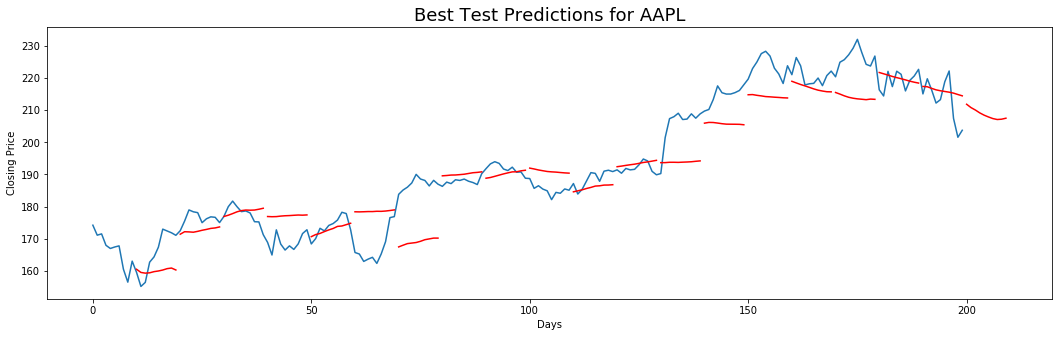

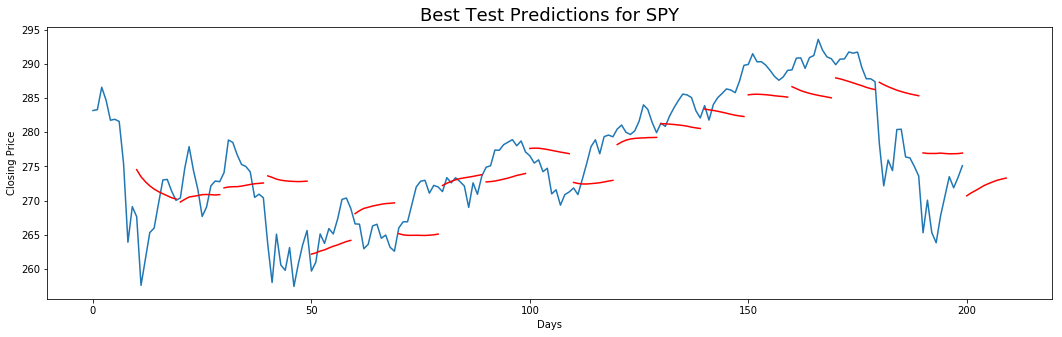

In [880]:
from matplotlib import pyplot as plt
from pandas import DataFrame as df
import time
plt.figure(figsize = (18,5))
plt.title('Best Test Predictions for AAPL',fontsize=18)
plt.xlabel('Days')
plt.ylabel('Closing Price')
plt.plot(range(0,batchsize*prediction_len),x_inv[:,:,0].reshape(-1,1))
for i in range(batchsize):
    plt.plot(range((i+1)*prediction_len,(i+2)*prediction_len),y_inv[i,:,0],'r')

plt.figure(figsize = (18,5))
plt.title('Best Test Predictions for SPY',fontsize=18)
plt.xlabel('Days')
plt.ylabel('Closing Price')
plt.plot(range(0,batchsize*prediction_len),x_inv[:,:,2].reshape(-1,1))
for i in range(batchsize):
    plt.plot(range((i+1)*prediction_len,(i+2)*prediction_len),y_inv[i,:,2],'r')

# Summary
The purpose of this project is to show how to implement multi-feature LSTM by Keras. Apparently the stock price prediction is imperfect by using the four features and 10-lag inputs. 

# Reference
* [LSTM from Keras](https://keras.io/layers/recurrent/#lstm)
* [Keras LSTM tutorial](http://adventuresinmachinelearning.com/keras-lstm-tutorial/)
* [Keras min max scaler](https://github.com/scikit-learn/scikit-learn/blob/bac89c2/sklearn/base.py#L438)
* [sequence prediction by "self-feeding"](https://www.altumintelligence.com/articles/a/Time-Series-Prediction-Using-LSTM-Deep-Neural-Networks)
* [sequence prediction by "self-feeding" (source)](https://github.com/jaungiers/LSTM-Neural-Network-for-Time-Series-Prediction/blob/master/core/model.py)
* [What is TimeDistributed in Keras doing?](https://stackoverflow.com/questions/47305618/what-is-the-role-of-timedistributed-layer-in-keras)
* [Many-to-many or Many-to-one?](https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/)